# Imports

In [1]:
import mesa
import math
import warnings

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from mesa.visualization import SolaraViz, make_space_component, make_plot_component

warnings.filterwarnings("ignore")

# Helper Functions

In [2]:
def get_distance(starting_pos, end_pos):
    """
    Calculate the Euclidian distance between 2 points
    """

    x1, y1 = starting_pos
    x2, y2 = end_pos

    dx = x2 - x1
    dy = y2 - y1

    return math.sqrt(dx**2 + dy**2)

def flatten(list_of_lists):
    """
    helper function for model data collector for trade price

    collapses agent pric list into ont list
    """
    return [item for sublist in list_of_lists for item in sublist]

def geometric_mean(list_of_prices):
    """
    find the geometric mean from a list of prices 
    """

    return np.exp(np.log(list_of_prices).mean())

def get_trade(agent):
    """
    For agent reporters in data collector

    return list of agent trade partners and None for other agents
    """
    if isinstance(agent, Trader):
        return agent.trade_partners
    else:
        return None



# Resource Classes

In [3]:
class Sugar(mesa.Agent):
    """
    Sugar:
    - agent that contains an amount sugar
    - grows one amount of sugar at each iteration of the model
    """

    def __init__(self, model, max_sugar):
        super().__init__(
            model=model
        )

        self.amount = max_sugar # current amount of sugar
        self.max_sugar = max_sugar

    def step(self):
        """
        Sugar growth function, adds one unit of sugar each step until
        we reach max_amount
        """
        self.amount = min([self.max_sugar, self.amount+1])
        # print("Sugar Agent:", self.unique_id, self.amount, self.max_sugar)

In [4]:
class Spice(mesa.Agent):
    """
    Spice:
    - agent that contains an amount of spice
    - grows one amouunt of augar at each iteration of the model
    """
    def __init__(self, model, max_spice):
        super().__init__(
            model=model
        )

        self.amount = max_spice
        self.max_spice = max_spice

    def step(self):
        """
        Spice growth function, adds one unit of spice each step until
        we reach max_amount
        """
        self.amount = min([self.max_spice, self.amount+1])
        # print("Spice Agent:", self.unique_id, self.amount, self.max_spice)

# Trader Class

In [5]:
class Trader(mesa.Agent):
    """
    Trader:
    - has a metabolism for sugar and spice
    - harvests and traders surgar and spice
    """

    def __init__(
        self,
        model,
        moore=False, # type of neighborhood (up, down, left, right, diagnol)
        sugar=0,
        spice=0,
        metabolism_sugar=0,
        metabolism_spice=0,
        vision=0
    ):
        super().__init__(model)

        self.moore = moore
        self.sugar = sugar
        self.spice = spice
        self.metabolism_sugar = metabolism_sugar
        self.metabolism_spice = metabolism_spice
        self.vision = vision
        self.prices = []
        self.trade_partners = []

    def get_sugar(self, pos):
        """
        Used in self.get_sugar_amount()
        """
        this_cell = self.model.grid.get_cell_list_contents(pos)

        for agent in this_cell:
            if type(agent) is Sugar:
                return agent
        
        return None

    def get_spice(self, pos):
        """
        Used in self.get_spice_amount()
        """
        this_cell = self.model.grid.get_cell_list_contents(pos)

        for agent in this_cell:
            if type(agent) is Spice:
                return agent
            
        return None

    def get_sugar_amount(self, pos):
        """
        Used in self.move() as apart of self.calculate_welfare()
        """
        sugar_patch = self.get_sugar(pos)

        if sugar_patch:
            # print("Sugar:", sugar_patch.amount)
            return sugar_patch.amount
        
        return 0

    def get_spice_amount(self, pos):
        """
        used in self.move() as apart of self.calculcate_welfare()
        """

        spice_patch = self.get_spice(pos)

        if spice_patch:
            # print("Spice:", spice_patch)
            return spice_patch.amount
        
        return 0

    def get_trader(self, pos):
        """
        Helper function in self.trade
        """
        this_cell = self.model.grid.get_cell_list_contents(pos)

        for agent in this_cell:
            if isinstance(agent, Trader):
                return agent

    def is_occupied_by_other(self, pos):
        """
        helper functin part of self.move()
        """
        if pos == self.pos:
            # agents position is considered unoccupied as agent can stay there
            return False
        
        # get contents of each cell in neighborhood
        this_cell = self.model.grid.get_cell_list_contents(pos)

        for a in this_cell:
            # see if occupied by another agent
            if isinstance(a, Trader):
                return True

        return False
    

    def calculate_welfare(self, sugar, spice):
        """
        Helper function part 2 self.move()

        using the cobb douglass function to determine welfare
        """

        # calculate total resources
        m_total = self.metabolism_sugar + self.metabolism_spice

        # Cobb-Douglass function form (pg. 97 of growing artificial socities)
        # print(sugar**(self.metabolism_sugar/m_total) * spice**(self.metabolism_spice/m_total))
        return sugar**(self.metabolism_sugar/m_total) * spice**(self.metabolism_spice/m_total)
    
    def is_starved(self):
        """
        helper function for self.maybe_die()
        """
        return (self.sugar <= 0) or (self.spice <= 0)
    
    def calculate_MRS(self):
        """
        helper function for self.trade()
        
        Determine what trader agent needs and can give up
        """
        return (self.spice/self.metabolism_spice) / (self.sugar/self.metabolism_sugar)


    def calculate_sell_spice_amount(self, price):
        """
        determine how spice or sugar is being traded for each of unit of spice or sugar
        based on the price that was established

        helper function for self.maybe_sell_spice
        """
        if price >= 1:
            sugar = 1
            spice = int(price)
        else:
            sugar = int(1/price)
            spice = 1

        return sugar, spice

    def sell_spice(self, other, sugar, spice):
        """
        used in maybe_sell_spice()
        executes the trade (exchanges sugar and spice)
        """
        self.sugar += sugar
        other.sugar -= sugar
        self.spice -= spice
        other.spice += spice

    def maybe_sell_spice(self, other, price, welfare_self, welfare_other):
        """
        helper function for self.trade
        """
        # pg 105 of GAS
        sugar_exchange, spice_exchange = self.calculate_sell_spice_amount(price)

        # Assess new sugar and spice amount - what if change did occur
        self_sugar = self.sugar + sugar_exchange
        other_sugar = other.sugar - sugar_exchange

        self_spice = self.spice - spice_exchange
        other_spice = other.spice + spice_exchange

        # double check to ensure agent have resources
        if ((self_sugar <= 0) or (other_sugar <= 0) or (self_spice <= 0) or (other_spice <= 0)):
            return False

        # trade criteria #1 - are both agents better off
        both_agents_better_off = (
            (welfare_self < self.calculate_welfare(self_sugar, self_spice))
            and (welfare_other < other.calculate_welfare(other_sugar, other_spice))
        )

        # trade criteria #2 - is their MRS crossing
        mrs_not_crossing = self.calculate_MRS() > other.calculate_MRS()

        # print(both_agents_better_off, mrs_not_crossing)

        if not (both_agents_better_off and mrs_not_crossing):
            return False
        
        # criteria met, execute trade
        self.sell_spice(other, sugar_exchange, spice_exchange)

        return True
    
    def trade(self, other):
        """
        helper function used in trade_with_neighbors()

        other is a trader agent object
        """
        # sanity check to verify code is working as expected
        assert self.sugar >= 0
        assert self.spice >= 0
        assert other.sugar >= 0
        assert other.spice >= 0

        # marginal rate of subsitution (pg. 101 growing artificial societies)
        mrs_self = self.calculate_MRS()
        mrs_other = other.calculate_MRS()

        # calculate each agents welfare
        welfare_self = self.calculate_welfare(self.sugar, self.spice)
        welfare_other = self.calculate_welfare(other.sugar, other.spice)

        # if agent have a relative close MRS they don't want to
        # to trade w/ each other and end the function
        if math.isclose(mrs_self, mrs_other):
            # print("It was close")
            return 

        # calculate price (based on the geometric mean)
        price = math.sqrt(mrs_self*mrs_other)

        if mrs_self > mrs_other:
            # self is a sugar buyer and spice seller
            sold = self.maybe_sell_spice(other, price, welfare_self, welfare_other)

            # no trade - criteria not met
            if not sold:
                return
        else:
            # self is a spice buyer and sugar seller
            sold = other.maybe_sell_spice(self, price, welfare_other, welfare_self)

            # no trade - criteria not met
            if not sold:
                return

        # capture data of trade
        self.prices.append(price)
        self.trade_partners.append(other.unique_id)

        # continue trading recursivley 
        self.trade(other)


    def move(self):
        """
        Function for trader agent to identify optimal move for each step in 4 parts
        1 - identify all possible moves
        2 - determine which move maximize welfare
        3 - find closest best option
        4 - move 
        """
        # print(f"i am agent {self.unique_id} and am about to move")

        # 1. identify all possible moves
        # radius is the vision of the agent
        neighbors = [
            i for i in self.model.grid.get_neighborhood(
                pos=self.pos,
                moore=self.moore,
                include_center=True,
                radius=self.vision
            ) if not self.is_occupied_by_other(i)
        ]

        # print(f"Position: {self.pos}\nVision: {self.vision}\nNeighbors: {neighbors}")

        # if sugar or spice < 0, a complex number will be calculated for
        # welfare and will cause max() function below to break
        if self.sugar < 0:
            self.sugar = 0

        if self.spice < 0:
            self.spice = 0

        # 2. determine which move maximizes welfare
        welfares = [
            self.calculate_welfare(
                self.sugar + self.get_sugar_amount(pos),
                self.spice + self.get_spice_amount(pos)
            ) for pos in neighbors
        ]

        # print(welfares)

        # 3. find closest best option

        # find highest welfare
        # try:
        max_welfare = max(welfares)
        # except TypeError as e:
        #     print("Agent:", self.unique_id)
        #     print("Sugar:", self.sugar)
        #     print("Spice:", self.spice)
        #     print("Neighbors:", neighbors)
        #     print("Welfares:", welfares)
        #     raise TypeError(e)


        # get the index of max welfare cells
        candidate_indices = [
            i for i in range(len(welfares))
            if math.isclose(welfares[i], max_welfare)
        ]

        # convert index to positions of those cells
        candidates = [neighbors[i] for i in candidate_indices]

        # print("N:", neighbors, "\nW:", welfares, "\nCI:", candidate_indices, "\nC:", candidates)

        min_dist = min(get_distance(self.pos, pos) for pos in candidates)
        
        final_candidates = [
            pos for pos in candidates
            if math.isclose(get_distance(self.pos, pos), min_dist, rel_tol=1e-02)
        ]

        self.random.shuffle(final_candidates)

        # 4. move agent
        self.model.grid.move_agent(self, final_candidates[0])

        # print(min_dist, final_candidates)

    def eat(self):
        """
        function for agent to consume sugar and spice
        """
        # print(f"Before eating:\nSugar: {self.sugar}\nSpice: {self.spice}\n")

        # get sugar and spice
        sugar_patch = self.get_sugar(pos=self.pos)
        spice_patch = self.get_spice(pos=self.pos)

        if sugar_patch:
            self.sugar += sugar_patch.amount
            sugar_patch.amount = 0

        if spice_patch:
            self.spice += spice_patch.amount
            spice_patch.amount = 0

        self.sugar -= self.metabolism_sugar
        self.spice -= self.metabolism_spice

        # print(f"After eating:\nSugar: {self.sugar}\nSpice: {self.spice}\n")

    def maybe_die(self):
        """
        If an agent has no more surgar spice resources they need to be removed
        function to remove traders who have consumed all their sugar or spice
        """

        if self.is_starved():
            # print("Number of agent in model:", len(self.model.agents_by_type[Trader]))
            self.remove()
            self.model.grid.remove_agent(self)
            # print("Dead trader:", self.unique_id)
            # print("Number of agent in model now:", len(self.model.agents_by_type[Trader]), "\n")

    def trade_with_neighbors(self):
        """
        Function for trader agents to deicde who to trade with in three parts
        1. identify neigbors who can trade
        2. trade
        3. collect data
        """
        neighbor_agents = [
            self.get_trader(pos) for pos in self.model.grid.get_neighborhood(
                pos=self.pos,
                moore=self.moore,
                include_center=False,
                radius=self.vision
            ) if self.is_occupied_by_other(pos)
        ]

        # print(neighbor_agents)

        if len(neighbor_agents) == 0:
            return

        # iterate through traders in neighboring cells and trade
        for a in neighbor_agents:
            if a:
                self.trade(a)

        return

# Model Class

In [6]:
class SugarscapeG1mt(mesa.Model):
    """
    A model class to manage Surgarscpae with Traders (G1mt)
    from Groing Artificial Societies by Axtell and Epstein
    """

    def __init__(
        self,
        width=50,
        height=50,
        initial_population=200,
        endowment_min=25,
        endowment_max=50,
        metabolism_min=1,
        metabolism_max=5,
        vision_min=1,
        vision_max=5
    ):
        super().__init__()

        # parameters for the landscape
        self.width = width
        self.height = height

        # population attributes
        self.initial_population = initial_population
        self.endowment_min = endowment_min
        self.endowment_max = endowment_max
        self.metabolism_min = metabolism_min
        self.metabolism_max = metabolism_max
        self.vision_min = vision_min
        self.vision_max = vision_max
        
        # for batch funcitonality
        self.running = True

        # instatiate mesa grid class to create our gride space
        # on where to load our agents
        self.grid = mesa.space.MultiGrid(self.width, self.height, torus=False)

        # initiate data collector
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Trader": lambda m: len(list(m.agents_by_type[Trader])),
                "Trade Volume": lambda m: sum(len(a.trade_partners) for a in m.agents_by_type[Trader]),
                "Price": lambda m: geometric_mean(flatten([a.prices for a in m.agents_by_type[Trader]]))
            },
            agent_reporters={"Trade Network": lambda a: get_trade(a)}
        )

        # read in landscape file
        sugar_distribution = np.genfromtxt("sugar-map.txt")
        spice_distribution = np.flip(sugar_distribution, 1)

        # plt.imshow(spice_distribution, origin="lower")

        # coor_iter() iterates over every grid cell in mesa's space function
        for _, (x, y) in self.grid.coord_iter():
            max_sugar = sugar_distribution[x, y]
            max_spice = spice_distribution[x, y]

            if max_sugar > 0:
                # instatiate sugar agent
                sugar = Sugar(
                    model=self,
                    max_sugar=max_sugar
                )

                # place agent on grid
                self.grid.place_agent(
                    agent=sugar,
                    pos=(x,y)
                )
            
            if max_spice > 0:
                spice = Spice(
                    model=self,
                    max_spice=max_spice
                )

                self.grid.place_agent(
                    agent=spice,
                    pos=(x,y)
                )

        for i in range(self.initial_population):
            # get agent positions
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)

            # see growing artificial societies p. 108 for parameter initialization
            # give agents initial endowment
            sugar = int(self.random.uniform(self.endowment_min, self.endowment_max+1))
            spice = int(self.random.uniform(self.endowment_min, self.endowment_max+1))

            metabolism_sugar = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))
            metabolism_spice = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))

            vision = int(self.random.uniform(self.vision_min, self.vision_max+1))

            trader = Trader(
                self,
                moore=False,
                sugar=sugar,
                spice=spice,
                metabolism_sugar=metabolism_sugar,
                metabolism_spice=metabolism_spice,
                vision=vision
            )

            self.grid.place_agent(trader, (x, y))

    def step(self):
        """
        Unique step function that does stage activation of sugar and spice
        abd then randomly activates traders
        """
        # random activation by type for Sugar and Spice agents
        for agent_class in [Sugar, Spice]:
            self.agents_by_type[agent_class].shuffle_do("step")

        # step for Trader agents
        # to account for agent death and removal we need a sparate data structure
        # to iterate. We shuffle to not have movers advantage
        trader_shuffle = list(self.agents_by_type[Trader].shuffle())

        for agent in trader_shuffle:
            agent.prices = []
            agent.trade_partners = []
            agent.move()
            agent.eat()
            agent.maybe_die()
        
        # shuffle again to not include agent that might have died in the previous step
        trader_shuffle = list(self.agents_by_type[Trader].shuffle())

        for agent in trader_shuffle:
            agent.trade_with_neighbors()
            # print(agent.prices, agent.trade_partners)

        # collect model level data
        self.datacollector.collect(self)
    
    def run_model(self, steps=1000, print_steps=False):
        print("Running model ...")
        
        for i in range(steps):
            if print_steps:
                print(f"Step {i} finished ...")

            self.step()
        
        print("Model complete!")

# Model exe

In [9]:
model = SugarscapeG1mt()

In [10]:
model.run_model(steps=1000)

Running model ...
Model complete!


# Analyze Data

## Model

In [12]:
model_results = model.datacollector.get_model_vars_dataframe()

<Axes: >

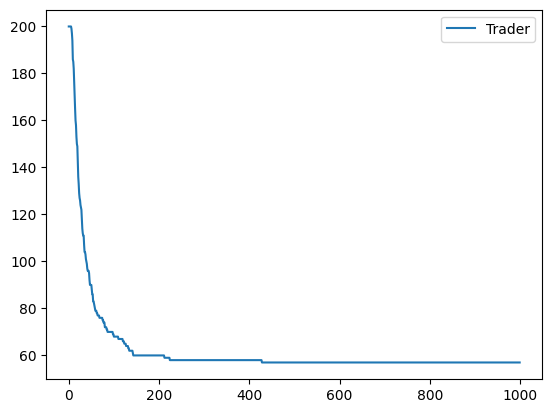

In [13]:
# Number of Trader agents on the landscape per time step

model_results.plot(y="Trader", use_index=True)

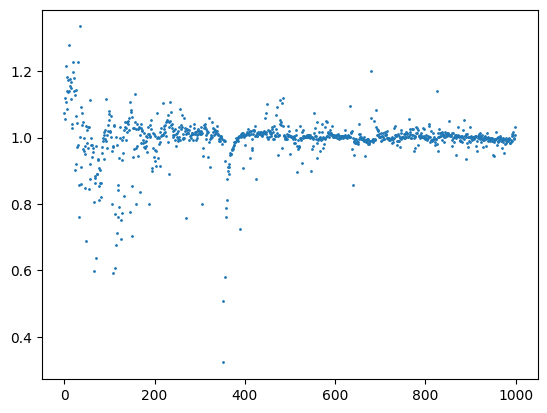

In [15]:
# Trade price per step

y = list(model_results["Price"].values)
x = range(1000)

plt.scatter(x, y, s=1)

# Trade price is averaging around 1.0

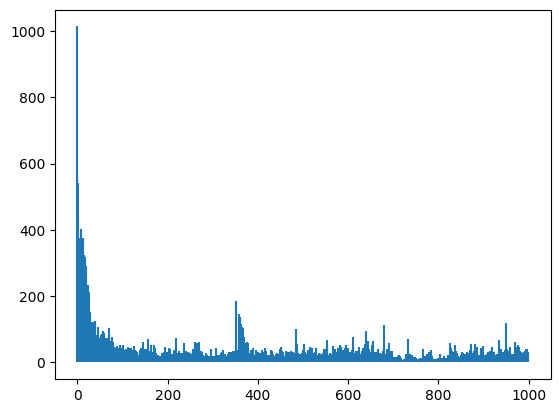

In [16]:
# Trade volume per step

# plt.bar(model_results.index, model_results["Trade Volume"])

for i in range(1000):
    plt.vlines(i, 0, model_results["Trade Volume"][i])

## Agent

In [17]:
agent_results = model.datacollector.get_agent_vars_dataframe()

agent_results = agent_results[
    agent_results["Trade Network"].notnull()
]

In [18]:
# create graph object

G = nx.Graph()

# add agent keys to make initial node set
G.add_nodes_from(list(model.agents_by_type[Trader].get(attr_names='unique_id')))

# create edge list
for idx, row in agent_results.iterrows():
    if len(row["Trade Network"]) > 0:
        for agent in row["Trade Network"]:
            G.add_edge(idx[1], agent)

In [ ]:
# Graph stats 

print("Node Connectivity:", nx.node_connectivity(G))
print("Graph Diameter:", [nx.diameter(G.subgraph(c).copy()) for c in nx.connected_components(G)]) # multiple numbers in list, there are sub graphs
print("Averge Clustering:", nx.average_clustering(G))
print("Global Efficiency:", nx.global_efficiency(G))

Node Connectivity: 0
Graph Diameter: [5, 3]
Averge Clustering: 0.5704183736165113
Global Efficiency: 0.501912611198322


#### Note on graph stats:
- Node Connectivity: This represents the minimum number of nodes that need to be removed to disconnect the graph.
- Graph Diameter: The maximum distance between any two vertices in a graph
- Average Clustering: Estimates the average clustering coefficient of G (which essentially tells you how likely it is for two neighbors of a node to also be connected to each other, providing insight into how tightly knit the network is overall).
- Global Efficiency: Shows how easily information can traverse across the network.

(array([52., 26., 27., 17., 14.,  8., 13., 12., 17., 10.]),
 array([ 1. ,  9.5, 18. , 26.5, 35. , 43.5, 52. , 60.5, 69. , 77.5, 86. ]),
 <BarContainer object of 10 artists>)

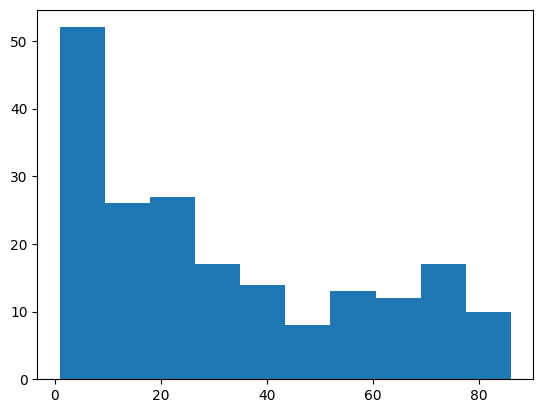

In [20]:
# the degree distbution of our agents

degrees = [d for n, d in G.degree()]
plt.hist(degrees)

In [21]:
import networkx as nx
import plotly.graph_objects as go

# Step 1: Get the node positions using a layout
pos = nx.spring_layout(G)  # Spring layout for better visualization

# Step 2: Extract edge traces for visualization
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Step 3: Extract node traces for visualization
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        size=10,
        color=[],
        line_width=2
    )
)

# Step 4: Add labels and colors to nodes
node_text = []
for node in G.nodes():
    node_text.append(f"Node {node}")
    # Example: Setting color based on degree
    node_trace.marker.color = [G.degree[n] for n in G.nodes()]

node_trace.text = node_text

# Step 6: Create the figure and plot
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='<br>Trade Network',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=0),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                ))

fig.show()

In [22]:
# Step 1: Get the node positions using a 3D layout
# Use a random layout with three dimensions
pos = nx.spring_layout(G, dim=3)

# Step 2: Extract edge traces for visualization
edge_x = []
edge_y = []
edge_z = []
for edge in G.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_z.extend([z0, z1, None])

edge_trace = go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Step 3: Extract node traces for visualization
node_x = []
node_y = []
node_z = []
for node in G.nodes():
    x, y, z = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_z.append(z)

node_trace = go.Scatter3d(
    x=node_x, y=node_y, z=node_z,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        size=10,
        color=[],
        colorscale='Viridis',  # Set color scale
        colorbar=dict(title="Node Connections"),
        line_width=1
    )
)

# Step 4: Add labels and colors to nodes
node_text = []
for node in G.nodes():
    node_text.append(f"Node {node}")
    # Example: Setting color based on degree
    node_trace.marker.color = [G.degree[n] for n in G.nodes()]

node_trace.text = node_text

# Step 5: Create the figure and plot
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='3D Trade Network',
                    titlefont_size=16,
                    showlegend=False,
                    margin=dict(l=0, r=0, t=0, b=0),
                    scene=dict(
                        xaxis=dict(showbackground=False),
                        yaxis=dict(showbackground=False),
                        zaxis=dict(showbackground=False)
                    )
                ))

fig.show()


# Batch Run & Analysis

In [23]:
params = {
    "width": 50,
    "height": 50,
    "vision_min": range(1, 3),
    "metabolism_max": [3, 5]
}

results_batch = mesa.batch_run(
    model_cls=SugarscapeG1mt,
    parameters=params,
    iterations=1,
    number_processes=1,
    data_collection_period=1,
    display_progress=True
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
results_df = pd.DataFrame(results_batch)

results_df.head()

,RunId,iteration,Step,width,height,vision_min,metabolism_max,Trader,Trade Volume,Price,AgentID,Trade Network
0,0,0,0,50,50,1,3,200,779,0.972395,NaN,NaN
1,0,0,1,50,50,1,3,200,465,0.985096,1.0,None
2,0,0,1,50,50,1,3,200,465,0.985096,2.0,None
3,0,0,1,50,50,1,3,200,465,0.985096,3.0,None
4,0,0,1,50,50,1,3,200,465,0.985096,4.0,None


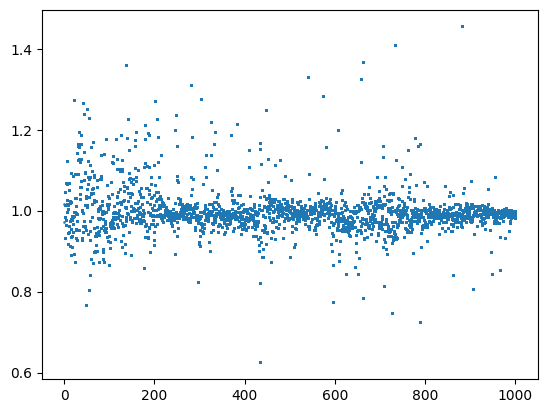

In [25]:
# looking at price where metabolism_max == 3

results_explore = results_df[
    (results_df["metabolism_max"] == 3)
]


plt.scatter(results_explore["Step"], results_explore["Price"], s=0.75)

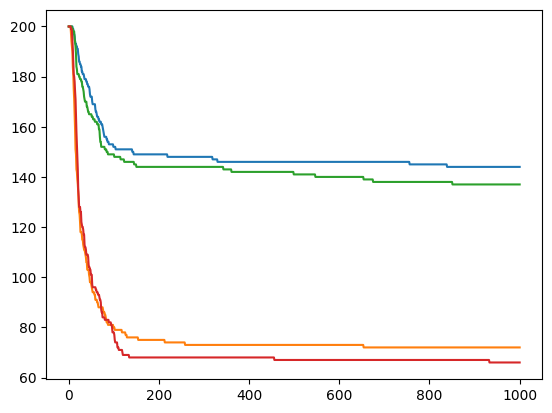

In [26]:
# Traders dying over time for each run

for i in range(4):
    results_explore = results_df[results_df["RunId"] == i]

    plt.plot(results_explore["Step"], results_explore["Trader"])

# Visualizing Model

In [27]:
def agent_portrayal(agent):
    """
    Define how agents are visualized.
    """
    if isinstance(agent, Trader):
        portrayal = {
            "Shape": "^",
            "color": "black",
            "size": 5,
            "layer": 3
        }

    elif isinstance(agent, Sugar):
        agent_color = {
            0: "red",
            1: "#f5dc7a",
            2: "#b5bfe5",
            3: "#6277ba",
            4: "#052696"
        }

        portrayal = {
            "color": agent_color[agent.amount],
            "size": 50,
            "layer": 2,
            # "Filled": True
        }

    elif isinstance(agent, Spice):
        agent_color = {
            0: "red",
            1: "#28BCE0",
            2: "#7343A9",
            3: "#9B0F8C",
            4: "#B8007F"
        }
        
        portrayal = {
            "color": agent_color[agent.amount],
            "size": 10,
            "Filled": True,
            "Layer": 1
        }
    else:
        portrayal = {}

    return portrayal

In [28]:
model_params = {
    "initial_population": {
        "type": "SliderInt",
        "value": 50,
        "label": "Initial Trader Population",
        "min": 50,
        "max": 200,
        "step": 1
    }
}

In [29]:
SpaceGraph = make_space_component(agent_portrayal=agent_portrayal)
TraderPlot = make_plot_component("Trader")
TraderVolumePlot = make_plot_component("Trade Volume")
PricePlot = make_plot_component("Price")

page = SolaraViz(model, components=[SpaceGraph, TraderPlot, TraderVolumePlot, PricePlot], name="Test", model_params=model_params)

In [30]:
page

Cannot show ipywidgets in text